In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Data Collection and Preparation:

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the usage data
data = pd.read_csv('/content/drive/MyDrive/GirlsScriptOpenSource/automarket/Task Recommendation Based on User Behavior /user_behavior_data.csv')

In [8]:
data.head()

,user_id,task_id,task_description,frequency,user_feedback
0,1,101,Automate email responses,10,5
1,1,102,Schedule social media posts,5,4
2,2,101,Automate email responses,7,4
3,2,103,Generate weekly reports,3,3
4,3,102,Schedule social media posts,8,5


In [9]:
data.tail()

,user_id,task_id,task_description,frequency,user_feedback
5,3,104,Data backup automation,2,3
6,3,105,File organization automation,4,4
7,4,103,Generate weekly reports,5,4
8,4,106,Customer feedback analysis,6,5
9,5,107,Inventory management automation,7,4


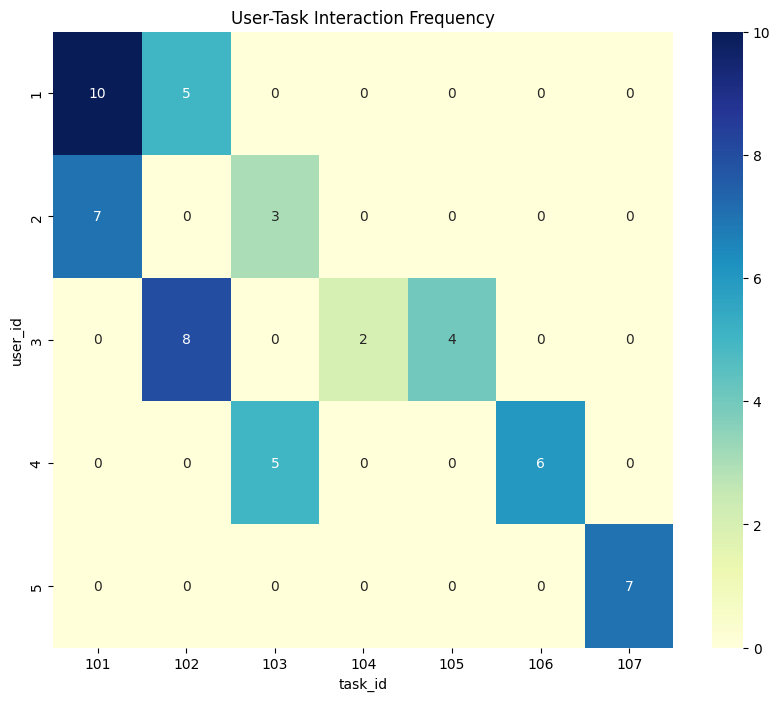

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
# Visualize user-task interactions
interaction_matrix = data.pivot_table(index='user_id', columns='task_id', values='frequency', aggfunc='sum', fill_value=0)

plt.figure(figsize=(10, 8))
sns.heatmap(interaction_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title('User-Task Interaction Frequency')
plt.show()


In [11]:
# Preprocess the data
data.fillna(0, inplace=True)
data['task_description'] = data['task_description'].str.lower()

In [12]:
# Split the data into training and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)


Feature Engineering:

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

In [14]:
# Vectorize task descriptions
vectorizer = TfidfVectorizer(max_features=5000)
X_desc = vectorizer.fit_transform(train_data['task_description'])

In [15]:
# Scale numerical features
scaler = StandardScaler()
X_numeric = scaler.fit_transform(train_data[['frequency', 'user_feedback']])

Collaborative Filtering:

In [16]:
from sklearn.decomposition import TruncatedSVD

In [17]:
# User-item matrix
user_item_matrix = train_data.pivot(index='user_id', columns='task_id', values='frequency').fillna(0)

In [18]:
# Apply SVD with a suitable number of components
n_components = min(50, user_item_matrix.shape[1])  # Choose the smaller value between 50 and number of features
svd = TruncatedSVD(n_components=n_components, random_state=42)
latent_matrix = svd.fit_transform(user_item_matrix)

Content-Based Filtering:

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate similarity scores
similarity_matrix = cosine_similarity(X_desc)

def get_similar_tasks(task_id, top_n=5):
    similar_tasks = similarity_matrix[task_id].argsort()[-top_n:]
    return similar_tasks


Model Evaluation

In [22]:
# Model Evaluation:

# For collaborative filtering, you can use metrics like RMSE, MAE, Precision@k, Recall@k
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predict ratings for the test set (replace with your actual prediction logic)
predicted_ratings = latent_matrix.dot(svd.components_)

# Convert predicted_ratings to a DataFrame for easier indexing
predicted_ratings_df = pd.DataFrame(predicted_ratings, index=user_item_matrix.index, columns=user_item_matrix.columns)

# Evaluate
test_user_item_matrix = test_data.pivot(index='user_id', columns='task_id', values='frequency').fillna(0)

# Get common users and tasks
common_users = predicted_ratings_df.index.intersection(test_user_item_matrix.index)
common_tasks = predicted_ratings_df.columns.intersection(test_user_item_matrix.columns)

# Subset the matrices based on common users and tasks
y_true = test_user_item_matrix.loc[common_users, common_tasks].values.flatten()
y_pred = predicted_ratings_df.loc[common_users, common_tasks].values.flatten()

rmse = mean_squared_error(y_true, y_pred, squared=False)
mae = mean_absolute_error(y_true, y_pred)

print("Collaborative Filtering RMSE:", rmse)
print("Collaborative Filtering MAE:", mae)

Collaborative Filtering RMSE: 3.5355339059327378
Collaborative Filtering MAE: 2.5


Predictions

In [23]:

# Get a user ID for prediction (replace with an actual user ID from your data)
user_id_to_predict = 1

# Get predicted ratings for this user
predicted_ratings_for_user = predicted_ratings_df.loc[user_id_to_predict]

# Get top N recommended tasks (replace N with the desired number of recommendations)
top_n_recommendations = predicted_ratings_for_user.sort_values(ascending=False).head(5)

print("Top recommended tasks for user", user_id_to_predict, ":")
for task_id, predicted_rating in top_n_recommendations.items():
    task_description = train_data[train_data['task_id'] == task_id]['task_description'].iloc[0]
    print("Task ID:", task_id, "- Description:", task_description, "- Predicted Rating:", predicted_rating)

Top recommended tasks for user 1 :
Task ID: 101 - Description: automate email responses - Predicted Rating: 9.999999999999986
Task ID: 104 - Description: data backup automation - Predicted Rating: 4.3519686824124095e-16
Task ID: 103 - Description: generate weekly reports - Predicted Rating: 2.235285494078296e-17
Task ID: 105 - Description: file organization automation - Predicted Rating: -9.511214549285382e-17
Task ID: 102 - Description: schedule social media posts - Predicted Rating: -2.5517027488891706e-16


In [ ]:
# we can integrate this with web and can show the prediction on web